# Test our method on the NLTT proper motion catalog

In [2]:
import os
import time
import glob
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
import corner
from scipy.interpolate import interp1d

%matplotlib inline

In [3]:
# Read in sample from Tycho-2 table

filename = ('../data/rNLTT/catalog_tabs.dat')
#t = Table.read(filename, format='ascii.fixed_width_no_header', guess=True)
t = Table.read(filename, format='ascii', guess=True)

In [4]:
print t.colnames

['NLTT', 'ra', 'dec', 'mu_ra', 'mu_dec', 'mu_ra_err', 'mu_dec_err', 'V', 'B', 'R', 'J', 'H', 'K']


In [20]:
print len(t['ra'])

36085


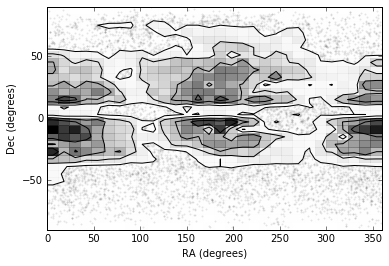

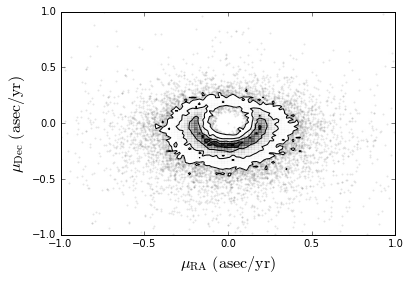

In [18]:
contourf_kwargs = {'bins':30}
corner.hist2d(t['ra'], t['dec'], range=[(0,360),(-90,90)], **contourf_kwargs)
#plt.scatter(t['ra'], t['dec'], marker='.', alpha=0.1)
plt.xlim(0,360)
plt.ylim(-90,90)
plt.xlabel('RA (degrees)')
plt.ylabel('Dec (degrees)')
plt.show()


contourf_kwargs = {'bins':100}
corner.hist2d(t['mu_ra'], t['mu_dec'], range=[(-1,1),(-1,1)], **contourf_kwargs)
#plt.scatter(t['mu_ra'], t['mu_dec'], marker='.', alpha=0.1)
plt.xlabel(r'$\mu_{\rm RA}\ {\rm (asec/yr)}$', size=16)
plt.ylabel(r'$\mu_{\rm Dec}\ {\rm (asec/yr)}$', size=16)
plt.xlim(-1,1)
plt.ylim(-1,1)

#plt.axes().set_aspect('equal')

plt.show()

In [162]:
def deg_to_rad(theta):
    """ Convert from degrees to radians """
    return np.pi * theta / 180.0

def rad_to_deg(theta):
    """ Convert from radians to degrees """
    return 180.0 * theta / np.pi

def get_theta_proj_degree(ra, dec, ra_b, dec_b):
    """ Return angular distance between two points

    Parameters
    ----------
    ra : float64
        Right ascension of first coordinate (degrees)
    dec : float64
        Declination of first coordinate (degrees)
    ra_b : float64
        Right ascension of second coordinate (degrees)
    dec_b : float64
        Declination of second coordinate (degrees)

    Returns
    -------
    theta : float64
        Angular distance (degrees)
    """

    ra1 = deg_to_rad(ra)
    dec1 = deg_to_rad(dec)
    ra2 = deg_to_rad(ra_b)
    dec2 = deg_to_rad(dec_b)

    dist = np.sqrt((ra1-ra2)**2 * np.cos(dec1)*np.cos(dec2) + (dec1-dec2)**2)

    
    
    print ra1, dec1, ra2, dec2
    
    return rad_to_deg(dist)



def nstars_nearby(ra, dec, radius=1.0, catalog=None):
    """ This function searches the catalog for all stars
    within some input radius.
        
    Arguments
    ---------
    ra, dec : float
        Search coordinate (degrees)
    radius : float
        Search radius (degrees)
    catalog : structure
        Catalog to search through
        
    Returns
    -------
    nstars : float
        Number of stars within given radius around input
        coordinate
    """
    
    if catalog is None: 
        print "You must supply an input catalog"
        return
    
    
    ra_rad1 = deg_to_rad(ra)
    dec_rad1 = deg_to_rad(dec)
    ra_rad2 = deg_to_rad(catalog['ra'])
    dec_rad2 = deg_to_rad(catalog['dec'])
    
    dist = rad_to_deg(np.sqrt((ra_rad1-ra_rad2)**2 * np.cos(dec_rad1)*np.cos(dec_rad2) + (dec_rad1-dec_rad2)**2))

    return len(np.where(dist<radius)[0])


def get_local_density(ra, dec, catalog=None):
    """ This function calculates the local stellar density
    
    Parameters
    ----------
    ra, dec : float
        Coordinates to find the local stellar density
    catalog : structure
        Catalog to search through
        
    Returns
    -------
    rho_star : float
        Local density of stars per square degree
    """
    
    # Estimate number density of stars from number of systems within 5 degrees
    rad = 5.0
    rho_star = (nstars_nearby(ra, dec, radius=rad, catalog=t)-1) / (4.0*np.pi* rad**2)

    return rho_star
    
    

In [ ]:
def get_P_mu(mu_ra, mu_dec, catalog=None):
    """ This function calculates the probability of a 
    random star having the observed proper motion
    
    Parameters
    ----------
    mu_ra, mu_dec : float
        Proper Motion likelihood to calculate
    catalog : structure
        Catalog to search through
        
    Returns
    -------
    P(mu) : float
        Probability of the proper motion
    """
    
    # Individual probabilities are independent, 
    # therefore P(mu) = P(mu_ra) * P(mu_dec)

    # P(mu_ra)
    vals, edges = np.histogram(t["mu_ra"], bins=nbins, normed=True, range=(mu_low, mu_high))
    bin_width = edges[1]-edges[0]
    bins = np.copy((edges[:-1]+0.5*bin_width))
    P_mu_ra = interp1d(bins, vals, bounds_error=False, fill_value=0.0)

    # P(mu_dec)
    vals, edges = np.histogram(t["mu_dec"], bins=nbins, normed=True, range=(mu_low, mu_high))
    bin_width = edges[1]-edges[0]
    bins = np.copy((edges[:-1]+0.5*bin_width))
    P_mu_dec = interp1d(bins, vals, bounds_error=False, fill_value=0.0)
    
    return P_mu_ra * P_mu_dec

### Check density distribution

23.7095699 33.0351181


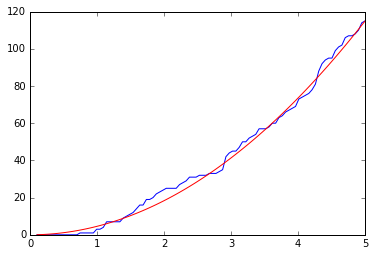

In [199]:
i=3344

ra_in = t['ra'][i]
dec_in = t['dec'][i] 
print ra_in, dec_in

radius = np.linspace(0.1, 5.0, 100)

nstars = np.array([])
for r in radius:
    nstars = np.append(nstars, nstars_nearby(ra_in, dec_in, radius=r, catalog=t)-1)
plt.plot(radius, nstars)

# Compare to density estimate derived from a 5 degree radius
radius = 5.0
y = (4.0*np.pi)*n_density*radius**2
plt.plot(radius,y, color='r')

plt.show()

### Check proper motion distribution

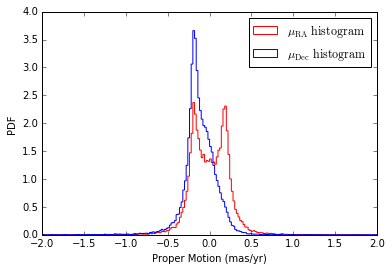

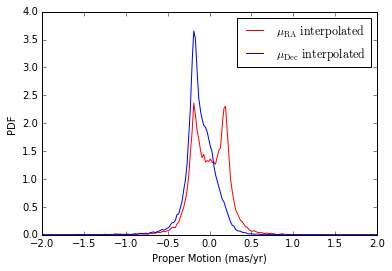

In [246]:
nbins = 200
mu_low, mu_high = -2.0, 2.0



# Histogram plot

# Plot histograms of data
plt.hist(t["mu_ra"], color='r', histtype='step', bins=nbins, range=(mu_low, mu_high), label=r'$\mu_{\rm RA}\ {\rm histogram}$', normed=True)
plt.hist(t["mu_dec"], color='b', histtype='step', bins=nbins, range=(mu_low, mu_high), label=r'$\mu_{\rm Dec}\ {\rm histogram}$', normed=True)

plt.ylabel('PDF')
plt.xlabel('Proper Motion (mas/yr)')

plt.legend()

plt.show()

# Interpolation plot

# P(mu_ra)
vals, edges = np.histogram(t["mu_ra"], bins=nbins, normed=True, range=(mu_low, mu_high))
bin_width = edges[1]-edges[0]
bins = np.copy((edges[:-1]+0.5*bin_width))
P_mu_ra = interp1d(bins, vals, bounds_error=False, fill_value=0.0)

# P(mu_dec)
vals, edges = np.histogram(t["mu_dec"], bins=nbins, normed=True, range=(mu_low, mu_high))
bin_width = edges[1]-edges[0]
bins = np.copy((edges[:-1]+0.5*bin_width))
P_mu_dec = interp1d(bins, vals, bounds_error=False, fill_value=0.0)

# Plot
x_test = np.linspace(-2.0, 2.0, 2000)
plt.plot(x_test, P_mu_ra(x_test), color='r', label=r'$\mu_{\rm RA}\ {\rm interpolated}$')
plt.plot(x_test, P_mu_dec(x_test), color='b', label=r'$\mu_{\rm Dec}\ {\rm interpolated}$')

plt.ylabel('PDF')
plt.xlabel('Proper Motion (mas/yr)')

plt.legend()

plt.show()